# Blood Cell Images for Cancer Detection

image

### Story

# Dependencies

In [180]:
# Standard 
import numpy as np
import pandas as pd

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Images
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Utility
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import time

# Neural network
import torch
import torch.nn as nn
from torch import optim

# Evaluation
from torchmetrics import Precision, Recall

# Transform for images

In [181]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Import images

In [182]:
train_data = ImageFolder(
    "data/train",
    transform = train_transform
)

test_data = ImageFolder(
    "data/test",
    transform = test_transform
)

# Create DataLoaders

In [183]:
def CreateDataLoaders(data, batch_size):
    """
    data: 
    Transformed images from train, validation or test folders

    batch_size: 
    Number of images loaded each batch
    """
    x = DataLoader(
        data,
        shuffle = True,
        batch_size = batch_size,
        )
    return x

# DataLoaders
train_dataloader = CreateDataLoaders(train_data, 16)
test_dataloader = CreateDataLoaders(test_data, 16)

# Print images and labels
images, labels = next(iter(train_dataloader))
print(images, labels)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

# Shape

In [184]:
print(images[0].shape)

torch.Size([3, 128, 128])


# Name encoding

In [185]:
# Names mapped to labels in dictionary
names = train_data.class_to_idx
print(names)

# Keys from dictionary to list
keys = list(names.keys())

{'basophil': 0, 'erythroblast': 1, 'monocyte': 2, 'myeloblast': 3, 'seg_neutrophil': 4}


# CNN

In [186]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.extract = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p = 0.1),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(32 * 32 * 32, n_classes)
        )

    def forward(self, x):
        x = self.extract(x)
        x = self.classifier(x)
        return x

# Model, optimizer, loss function and scheduler

In [187]:
# Model
net = Net(5)

# Optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=10e-4)

# Loss function
criterion = nn.CrossEntropyLoss()

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience=2, factor=0.1)

# Define metrics

In [188]:
# Defining metrics
metric_precision = Precision(task="multiclass", num_classes=5, average="weighted")
metric_recall = Recall(task="multiclass", num_classes=5, average="weighted")

# Training and testing

In [189]:
# Run n epochs
n_epochs = 20

# Early stop
counter = 0
paticence = 2
best_loss = np.inf

# Train and test losses
train_losses = []
test_losses = []

# Train and test accuracy
train_accuracies = []
test_accuracies = []

# Run loop
for epoch in range(n_epochs):
    # Start time
    start = time.time()

    # Loss
    train_total_loss = 0.0

    # Correct classification
    train_correct = 0.0
    train_count = 0.0

    # Loop
    for image, label in train_dataloader:
        optimizer.zero_grad()
        output = net(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # Accuracy
        _, pred = torch.max(output, 1)
        train_correct += (pred == label).sum().item()
        train_count += label.size(0)

        # Loss
        train_total_loss += loss.item()
    
    # Epoch train performance
    train_loss = train_total_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Train accuracy
    train_accuracy = train_correct / train_count
    train_accuracies.append(train_accuracy)

    # Testing loop
    net.eval()

    # Loss
    test_total_loss = 0

    # Labels
    true_labels = []
    pred_labels = []

    # Correct classification
    test_correct = 0.0
    test_count = 0.0

    # Loop
    with torch.no_grad():
        for image, label in test_dataloader:
            output = net(image)
            loss = criterion(output, label)
            
            # Predictions for heatmap
            _, pred = torch.max(output, 1)
            true_labels.extend(label)
            pred_labels.extend(pred)

            # Accuracy
            test_correct += (pred == label).sum().item()
            test_count += label.size(0)

            # Metrics
            metric_precision(pred, label)
            metric_recall(pred, label)

            # Loss
            test_total_loss += loss.item()
    
    # Epoch test performance
    test_loss = test_total_loss / len(test_dataloader)
    test_losses.append(test_loss)

    # Update learning rate based on test loss
    scheduler.step(metrics=test_loss)

    # Test accuracy
    test_accuracy = test_correct / test_count
    test_accuracies.append(test_accuracy)

    # Compute metrics for test images
    precision = metric_precision.compute()
    recall = metric_recall.compute()

    # Save best model
    if test_loss < best_loss:

        # Reset counter
        counter = 0

        # Save best model
        torch.save(net, "best_blood_cancer_classification.pth")
    else:

        # Counter increase by 1 
        counter += 1

    # Train loop switch
    net.train()

    # End time
    finish = time.time()

    # Early stop
    if counter >= paticence:
        print("Best model saved!")
        break

    # Print epoch results
    print(f'Epoch: {epoch + 1} ({finish-start:.2f} seconds)\nTrain accuracy: {train_accuracy:.4f} | Test accuracy: {test_accuracy:.4f} \nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} \nTest precision: {precision:.4f} | Test recall: {recall:.4f}\nEarly stop: {counter}/{paticence}\n')

Epoch: 1 (20.59 seconds)
Train accuracy: 0.7348 | Test accuracy: 0.6370 
Train loss: 1.4768 | Test loss: 2.2104 
Test precision: 0.7308 | Test recall: 0.6370
Early stop: 0/2

Epoch: 2 (20.53 seconds)
Train accuracy: 0.8635 | Test accuracy: 0.8670 
Train loss: 0.6884 | Test loss: 0.4724 
Test precision: 0.7932 | Test recall: 0.7520
Early stop: 0/2

Epoch: 3 (20.82 seconds)
Train accuracy: 0.9080 | Test accuracy: 0.9260 
Train loss: 0.4315 | Test loss: 0.3022 
Test precision: 0.8381 | Test recall: 0.8100
Early stop: 0/2

Epoch: 4 (21.19 seconds)
Train accuracy: 0.9265 | Test accuracy: 0.9510 
Train loss: 0.3263 | Test loss: 0.2115 
Test precision: 0.8615 | Test recall: 0.8452
Early stop: 0/2

Epoch: 5 (20.52 seconds)
Train accuracy: 0.9200 | Test accuracy: 0.9560 
Train loss: 0.3884 | Test loss: 0.2315 
Test precision: 0.8785 | Test recall: 0.8674
Early stop: 0/2

Epoch: 6 (20.78 seconds)
Train accuracy: 0.9387 | Test accuracy: 0.9810 
Train loss: 0.2539 | Test loss: 0.0981 
Test precisi

# Visualize loss

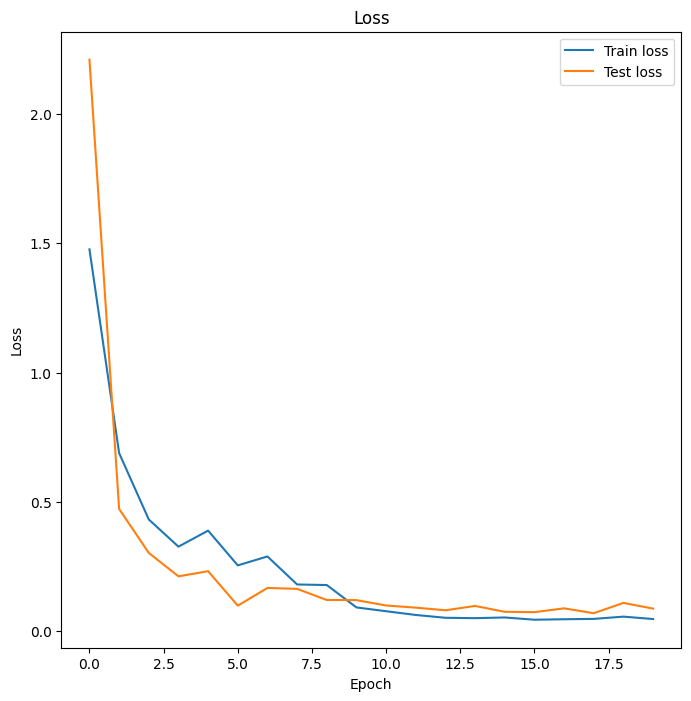

In [190]:
fig, ax = plt.subplots(figsize = (8, 8))

# Title
plt.title("Loss")

# Data
plt.plot(train_losses, label = "Train loss")
plt.plot(test_losses, label = "Test loss")

# Axis
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Legend
plt.legend()
plt.show()

# Visualize train and test accuracy

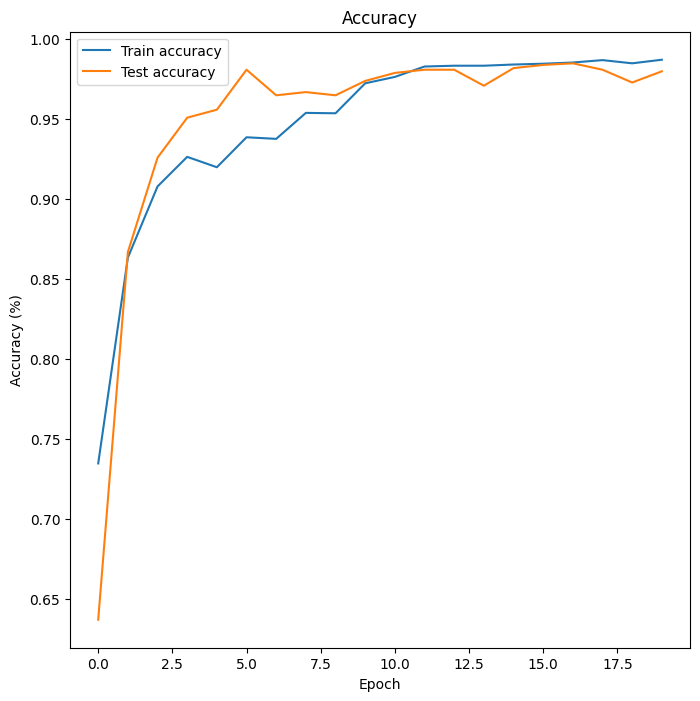

In [191]:
fig, ax = plt.subplots(figsize = (8, 8))

# Title
plt.title("Accuracy")

# Data
plt.plot(train_accuracies, label = "Train accuracy")
plt.plot(test_accuracies, label = "Test accuracy")

# Axis
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

# Legend
plt.legend()
plt.show()

# Confusion matrix

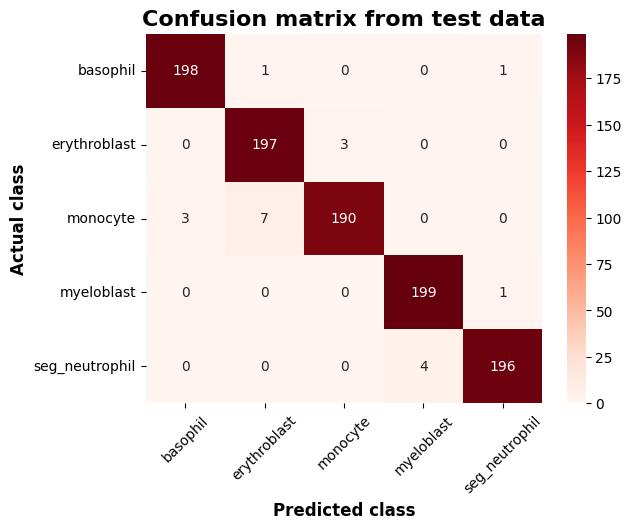

In [193]:
# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Figure


# Display confusion matrix
sns.heatmap(cm, annot=True, cmap="Reds", fmt="0.0f")

# Title
plt.title("Confusion matrix from test data", fontweight = "bold", fontsize = 16)

# Axis
plt.xlabel("Predicted class", fontweight = "bold", fontsize = 12)
plt.ylabel("Actual class", fontweight = "bold", fontsize = 12)
plt.xticks(np.arange(5)+0.5, keys, rotation = 45)
plt.yticks(np.arange(5)+0.5, keys, rotation = 0)
fig.savefig("confusion_matrix.png")
plt.show()